# Wine Quality Analysis and Model parameter tuning.

#### This work includes, basic data visualization, Modeling with XGB and also parameter tuning. After this we will come to know which set of parameters will give best accuracy after tuning. Here we have used Grid Search, Randomized search and Bayes Optimization techniques to tune the parameters.

In [1]:
#Clear ipython memory
%reset -f

#Data manipulation and plotting modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns

#Call Standarad Scaler
from sklearn.preprocessing import StandardScaler as ss

#Cal PCA for Dimensionality reduction
from sklearn.decomposition import PCA

#Data splitting and model parameter search
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization

#Call Modeling module, we will be using XBG for modeling.
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support

#Model pipelining
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


#Model evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix

# This is needed for Bayes optimization takes an estimator, performs cross-validation
# and gives out average score
from sklearn.model_selection import cross_val_score

#Find feature importance of ANY BLACK BOX estimator
import eli5
from eli5.sklearn import PermutationImportance


#Misc
import time
import os
import gc
import random
from scipy.stats import uniform

#Set option to dislay many rows
pd.set_option('display.max_columns', 100)


In [2]:
# Set working directory and set the filename
print(os.listdir("../input"))
os.listdir()
tr_f = "../input/winequalityN.csv"

['winequalityN.csv']


In [3]:
# Total number of rows. Here I am reading 99% rows, just wanted to show we can also read part of data.
total_lines = 6498
num_lines = 0.99 * total_lines    # 99% of data
num_lines
p = num_lines/total_lines
df = pd.read_csv(tr_f,header=0, # First row is header-row
         skiprows=lambda i: (i>0) and (random.random() > p))

In [4]:
#Below is the code to check and remove the any NaN values present in the rows.
print (df.isnull().sum())
data=df.dropna()
data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Basic data visualization

In [5]:
data.shape

(6406, 13)

In [6]:
data.columns.values 

array(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'], dtype=object)

In [7]:
data.dtypes.value_counts() 

float64    11
object      1
int64       1
dtype: int64

In [8]:
data.head(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [9]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000
mean,7.219287,0.339313,0.319081,5.445793,0.056073,30.500624,115.628864,0.994700,3.218138,0.531065,10.492028,5.818764
std,1.298385,0.164109,0.145266,4.758455,0.035095,17.765591,56.548055,0.003003,0.160522,0.148111,1.193123,0.872566
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [10]:
data.type.value_counts()

white    4826
red      1580
Name: type, dtype: int64

### Draw some graphs to understand the data more.

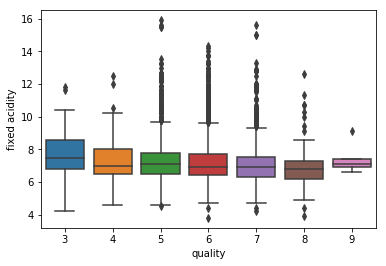

In [11]:
# Box plot to show quality and fixed acidity
sns.boxplot(x='quality',y='fixed acidity', data=data)

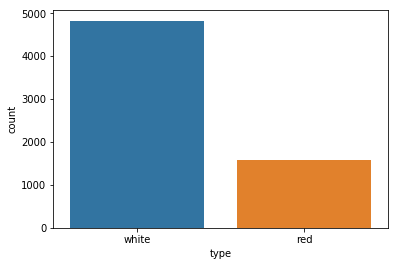

In [12]:
# Count plot to show how many white and red wine types are there.
sns.countplot(x='type',data=data)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


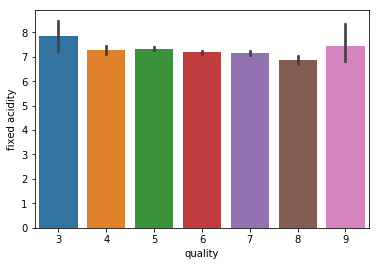

In [13]:
#Bar plot to show the quality and fixed acidity
sns.barplot(x = 'quality', y = 'fixed acidity', data = data)

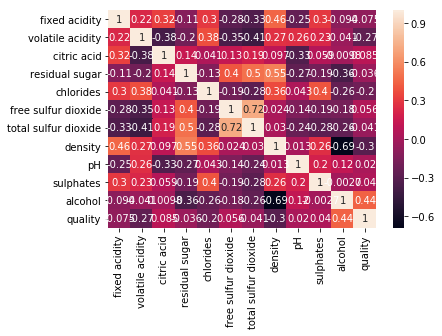

In [14]:
# Heat map to show the correlation between the feature columns.
sns.heatmap(data.corr(),annot=True)

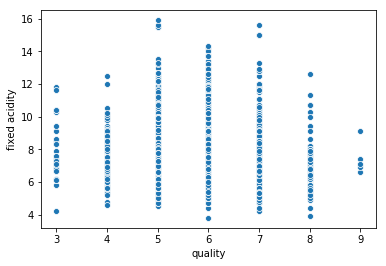

In [15]:
#Scatter plot to show the qulity and fixed acidity
sns.scatterplot("quality","fixed acidity",data=data)

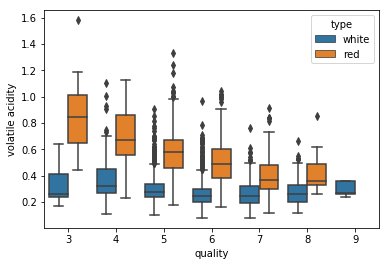

In [16]:
#boxplot to show quality and volatile acidty with type as hue parameter.
sns.boxplot(x="quality", y="volatile acidity",hue='type',data=data)

## Modelling and parameter tuning

In [17]:
# Separate the feature and target columns
X = data.iloc[ :, 1:13]
print (X.head(2))
y = data.iloc[ : , 0]
y.head(2)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   

   free sulfur dioxide  total sulfur dioxide  density   pH  sulphates  \
0                 45.0                 170.0    1.001  3.0       0.45   
1                 14.0                 132.0    0.994  3.3       0.49   

   alcohol  quality  
0      8.8        6  
1      9.5        6  


0    white
1    white
Name: type, dtype: object

In [18]:
#Map the target data to '1' and '0'
y = y.map({'white':1, 'red' : 0})
y.dtype

dtype('int64')

In [19]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: type, dtype: int64

In [20]:
# Split dataset into train and validation parts
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.35,
                                                    shuffle = True
                                                    )

In [21]:
print (X_train.shape)        
print (X_test.shape)         
print (y_train.shape)        
print (y_test.shape)

(4163, 12)
(2243, 12)
(4163,)
(2243,)


In [22]:
# Pipelining
steps_xg = [('sts', ss() ),
            ('pca', PCA()),
            ('xg',  XGBClassifier(silent = False,
                                  n_jobs=2)        
            )
            ]
pipe_xg = Pipeline(steps_xg)

### Grid Search

In [23]:
parameters = {'xg__learning_rate':  [0, 1],
              'xg__n_estimators':   [50,  100],  
              'xg__max_depth':      [3,5],
              'pca__n_components' : [5,7] }

In [24]:
clf = GridSearchCV(pipe_xg,            # pipeline object
                   parameters,         # possible parameters
                   n_jobs = 2,         # USe parallel cpu threads
                   cv =2 ,             # No of folds
                   verbose =2,         # Higher the value, more the verbosity
                   scoring = ['accuracy', 'roc_auc'],  # Metrics for performance
                   refit = 'roc_auc'   # Refitting final model on what parameters?
                                       # Those which maximise auc
                   )

In [25]:
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
(end - start)/60

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  32 out of  32 | elapsed:    8.7s finished
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.14891998370488485

In [26]:
f"Best score: {clf.best_score_} "

'Best score: 0.9955331245056688 '

In [27]:
f"Best parameter set {clf.best_params_}"

"Best parameter set {'pca__n_components': 5, 'xg__learning_rate': 1, 'xg__max_depth': 5, 'xg__n_estimators': 50}"

In [28]:
y_pred = clf.predict(X_test)
y_pred

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


array([1, 0, 0, ..., 1, 0, 1])

In [29]:
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"

'Accuracy: 98.7962550156041'

### Randomized Search

In [30]:
parameters = {'xg__learning_rate':  uniform(0, 1),
              'xg__n_estimators':   range(50,100),
              'xg__max_depth':      range(3,5),
              'pca__n_components' : range(5,7)}

In [31]:
rs = RandomizedSearchCV(pipe_xg,
                        param_distributions=parameters,
                        scoring= ['roc_auc', 'accuracy'],
                        n_iter=15,          
                                            
                        verbose = 3,
                        refit = 'roc_auc',
                        n_jobs = 2,          
                        cv = 2              
                                             
                        )

In [32]:
#Run random search for 25 iterations. 
start = time.time()
rs.fit(X_train, y_train)
end = time.time()
(end - start)/60

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    4.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.07507172028223673

In [33]:
f"Best score: {rs.best_score_} "

'Best score: 0.9956919100646345 '

In [34]:
f"Best parameter set: {rs.best_params_} "

"Best parameter set: {'pca__n_components': 5, 'xg__learning_rate': 0.325509936593261, 'xg__max_depth': 4, 'xg__n_estimators': 73} "

In [35]:
y_pred = rs.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


'Accuracy: 98.7962550156041'

### Bayes Optimization

In [36]:
para_set = {
           'learning_rate':  (0, 1),                 
           'n_estimators':   (50,100),               
           'max_depth':      (3,5),               
           'n_components' :  (5,7)                
            }


In [37]:
def xg_eval(learning_rate,n_estimators, max_depth,n_components):
    pipe_xg1 = make_pipeline (ss(),                        
                              PCA(n_components=int(round(n_components))),
                              XGBClassifier(
                                           silent = False,
                                           n_jobs=2,
                                           learning_rate=learning_rate,
                                           max_depth=int(round(max_depth)),
                                           n_estimators=int(round(n_estimators))
                                           )
                             )

    cv_result = cross_val_score(estimator = pipe_xg1,
                                X= X_train,
                                y = y_train,
                                cv = 2,
                                n_jobs = 2,
                                scoring = 'f1'
                                ).mean()             # take the average of all results


    return cv_result

In [38]:
xgBO = BayesianOptimization(
                             xg_eval,     # Function to evaluate performance.
                             para_set     # Parameter set from where parameters will be selected
                             )

In [39]:
start = time.time()
xgBO.maximize(init_points=5,    
               n_iter=25,        
               )
end = time.time()
(end-start)/60

|   iter    |  target   | learni... | max_depth | n_comp... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9914   |  0.631    |  4.906    |  5.979    |  95.43    |
|  2        |  0.9903   |  0.1144   |  4.851    |  5.46     |  52.48    |
|  3        |  0.9914   |  0.9404   |  3.575    |  6.276    |  61.17    |
|  4        |  0.9911   |  0.7284   |  4.498    |  6.966    |  99.39    |
|  5        |  0.9915   |  0.955    |  3.586    |  6.751    |  82.46    |
|  6        |  0.9915   |  0.8681   |  3.193    |  6.512    |  99.98    |
|  7        |  0.9901   |  0.0252   |  3.163    |  5.354    |  50.01    |
|  8        |  0.9914   |  0.4641   |  3.019    |  6.412    |  99.98    |
|  9        |  0.9914   |  0.3609   |  3.198    |  5.022    |  100.0    |
|  10       |  0.9925   |  0.7477   |  3.629    |  5.305    |  99.98    |
|  11       |  0.9901   |  0.153    |  4.906    |  5.01     |  99.99    |
|  12       |  0.9919   |  0.835    | 

3.8684720079104107

In [40]:
xgBO.res

[{'target': 0.9913751763621683,
  'params': {'learning_rate': 0.6310405496692258,
   'max_depth': 4.905586139995997,
   'n_components': 5.979290434976809,
   'n_estimators': 95.43161953214837}},
 {'target': 0.9902548407630191,
  'params': {'learning_rate': 0.1144407915538731,
   'max_depth': 4.850567928602615,
   'n_components': 5.46042174582158,
   'n_estimators': 52.47582521609293}},
 {'target': 0.9913755724556238,
  'params': {'learning_rate': 0.9404341424182943,
   'max_depth': 3.5750133114706912,
   'n_components': 6.2756452800572315,
   'n_estimators': 61.16701808338626}},
 {'target': 0.9910521248103088,
  'params': {'learning_rate': 0.7284036359320908,
   'max_depth': 4.498119601396599,
   'n_components': 6.966481761720916,
   'n_estimators': 99.39208784182156}},
 {'target': 0.9915386807243306,
  'params': {'learning_rate': 0.9549520965599362,
   'max_depth': 3.585691750321426,
   'n_components': 6.750580877734652,
   'n_estimators': 82.45680745268263}},
 {'target': 0.9915369590

In [41]:
xgBO.max

{'target': 0.9925017067929137,
 'params': {'learning_rate': 0.7476926652441086,
  'max_depth': 3.6290472288398137,
  'n_components': 5.304958267784073,
  'n_estimators': 99.97650662521058}}

## Model fitting using best parameters from above tuning techniques.

In [42]:
# Grid Search
xg_gs = XGBClassifier(learning_rate = clf.best_params_['xg__learning_rate'],
                    max_depth = clf.best_params_['xg__max_depth'],
                    n_estimators=clf.best_params_['xg__n_estimators'])
#Randomized search
xg_rs = XGBClassifier(learning_rate = rs.best_params_['xg__learning_rate'],
                    max_depth = rs.best_params_['xg__max_depth'],
                    n_estimators=rs.best_params_['xg__n_estimators'])
#Bayes Optimization
xg_bo = XGBClassifier(learning_rate = xgBO.max['params']['learning_rate'],
                    max_depth = int(xgBO.max['params']['max_depth']),
                    n_estimators= int(xgBO.max['params']['n_estimators']))

In [43]:
#Fit the data using X_Train and y_train
xg_gs1 = xg_gs.fit(X_train,y_train)
xg_rs1 = xg_rs.fit(X_train,y_train)
xg_bo1 = xg_bo.fit(X_train,y_train)

In [44]:
y_pred_xg_gs = xg_gs1.predict(X_test)
y_pred_xg_rs = xg_rs1.predict(X_test)
y_pred_xg_bo = xg_bo1.predict(X_test)

In [45]:
y_pred_xg_gs_prob = xg_gs1.predict_proba(X_test)
y_pred_xg_rs_prob = xg_rs1.predict_proba(X_test)
y_pred_xg_bo_prob = xg_bo1.predict_proba(X_test)

In [46]:
print (accuracy_score(y_test,y_pred_xg_gs))
print (accuracy_score(y_test,y_pred_xg_rs))
print (accuracy_score(y_test,y_pred_xg_bo))

0.9937583593401694
0.9946500222915737
0.9946500222915737


In [47]:
confusion_matrix(y_test,y_pred_xg_gs)
confusion_matrix(y_test,y_pred_xg_rs)
confusion_matrix(y_test,y_pred_xg_bo)

array([[ 545,    8],
       [   4, 1686]])

### ROC Graph

In [48]:
fpr_xg_gs, tpr_xg_gs, thresholds = roc_curve(y_test,
                                 y_pred_xg_gs_prob[: , 1],
                                 pos_label= 1
                                 )
fpr_xg_rs, tpr_xg_rs, thresholds = roc_curve(y_test,
                                 y_pred_xg_rs_prob[: , 1],
                                 pos_label= 1
                                 )
fpr_xg_bo, tpr_xg_bo, thresholds = roc_curve(y_test,
                                 y_pred_xg_bo_prob[: , 1],
                                 pos_label= 1
                                 )

### Calculate the Precision, Recall and F1 Score

In [49]:
p_xg_gs,r_xg_gs,f_xg_gs,_ = precision_recall_fscore_support(y_test,y_pred_xg_gs)
p_xg_rs,r_xg_rs,f_xg_rs,_ = precision_recall_fscore_support(y_test,y_pred_xg_rs)
p_xg_bo,r_xg_bo,f_xg_bo,_ = precision_recall_fscore_support(y_test,y_pred_xg_bo)

### Calculate the AUC(Area Under the ROC Curve).

In [50]:
print (auc(fpr_xg_gs,tpr_xg_gs))
print (auc(fpr_xg_rs,tpr_xg_rs))
print (auc(fpr_xg_bo,tpr_xg_bo))

0.9978974287640305
0.9974630043763444
0.9965278149309308


### Below is the plotting the ROC curve for all the models.

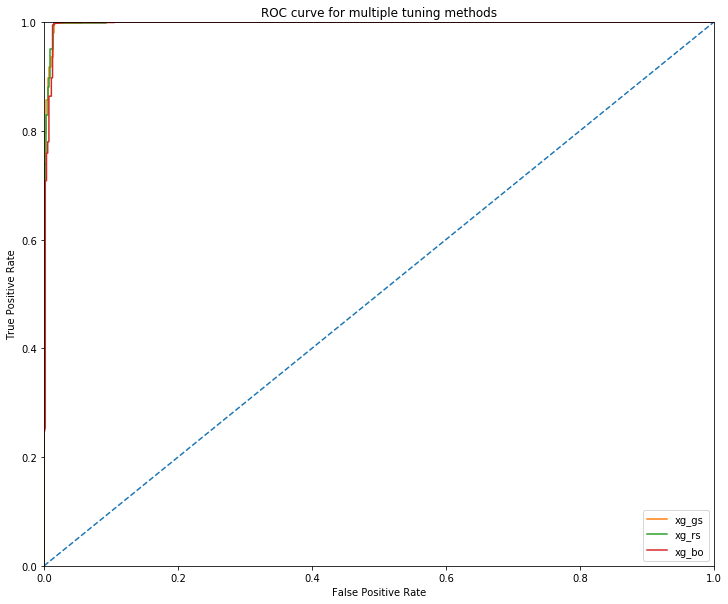

In [51]:
fig = plt.figure(figsize=(12,10))          # Create window frame
ax = fig.add_subplot(111)   # Create axes
# 9.2 Also connect diagonals
ax.plot([0, 1], [0, 1], ls="--")   # Dashed diagonal line
# 9.3 Labels etc
ax.set_xlabel('False Positive Rate')  # Final plot decorations
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for multiple tuning methods')
# 9.4 Set graph limits
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

# 9.5 Plot each graph now
ax.plot(fpr_xg_gs, tpr_xg_gs, label = "xg_gs")
ax.plot(fpr_xg_rs, tpr_xg_rs, label = "xg_rs")
ax.plot(fpr_xg_bo, tpr_xg_bo, label = "xg_bo")
# 9.6 Set legend and show plot
ax.legend(loc="lower right")
plt.show()